<a href="https://colab.research.google.com/github/dmunozbe/TFM_DataScience/blob/main/Forecasting/05.%20Sarria-Sant%20Gervasi/Forecasting_(Indicador_73).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Forecasting**




**Forecasting** es el proceso de predecir eventos futuros basados en patrones históricos y datos existentes.

El objetivo principal es el de hacer predicciones precisas sobre el futuro utilizando datos pasados y presentes y se utiliza en una amplia variaedad de constextos, como en finanzas, meteorologia, ventas entre otros

Se realizaran comprobaciones de cointegracion, estacionariedad, para determinar que modelo aplicar entre los seleccionados:

* Modelos VAR (Vector Autoregressive)
* Modelos VARMA (Vector Autoregressive Moving Average)
* Modelos VARMAx (VARMA con Variables Exógenas)
* Modelos VECM (Vector Error Correlation Model)

##Importar bibliotecas

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn import metrics


import warnings
warnings.filterwarnings("ignore")

##Carga de datos

In [2]:
# Cargar datos
data = pd.read_csv('/content/drive/MyDrive/UOC/TFM/Datasets definitivos/Final.csv')
data.head()

,Any,Trimestre,Mes,Codi_Districte,Nom_Districte,Codi_Barri,Nom_Barri,Compraventa_Unitario,ParadosReg,Estudios_Obligatorios,ConsumResidencial,Pm25,Pm10,Participacion,AñosEspVida,Internet,Movil,Index_Turisme,m² por habitante
0,2014,1,1,1,Ciutat Vella,1,el Raval,2813.0,4588,NaN,NaN,NaN,NaN,41.8,80.7,NaN,NaN,NaN,6.2
1,2014,1,2,1,Ciutat Vella,1,el Raval,2813.0,4539,NaN,NaN,NaN,NaN,41.8,80.7,NaN,NaN,NaN,6.2
2,2014,1,3,1,Ciutat Vella,1,el Raval,2813.0,4572,NaN,NaN,NaN,NaN,41.8,80.7,NaN,NaN,NaN,6.2
3,2014,2,4,1,Ciutat Vella,1,el Raval,2948.8,4510,NaN,NaN,NaN,NaN,41.8,80.7,NaN,NaN,NaN,6.2
4,2014,2,5,1,Ciutat Vella,1,el Raval,2948.8,4379,NaN,NaN,NaN,NaN,41.8,80.7,NaN,NaN,NaN,6.2


In [3]:
print(data.dtypes)

Any                        int64
Trimestre                  int64
Mes                        int64
Codi_Districte             int64
Nom_Districte             object
Codi_Barri                 int64
Nom_Barri                 object
Compraventa_Unitario     float64
ParadosReg                 int64
Estudios_Obligatorios    float64
ConsumResidencial        float64
Pm25                     float64
Pm10                     float64
Participacion            float64
AñosEspVida              float64
Internet                 float64
Movil                    float64
Index_Turisme            float64
m² por habitante         float64
dtype: object


## Analisis por grupo de indicadores (Internet)

### Preparacion de datos

In [4]:
df_sel = data[['Any','Trimestre','Mes','Codi_Districte','Nom_Districte','Codi_Barri','Nom_Barri','Compraventa_Unitario','Internet']]

In [5]:
df_cont = df_sel.dropna()

In [6]:
df_cont.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6132 entries, 1752 to 7883
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Any                   6132 non-null   int64  
 1   Trimestre             6132 non-null   int64  
 2   Mes                   6132 non-null   int64  
 3   Codi_Districte        6132 non-null   int64  
 4   Nom_Districte         6132 non-null   object 
 5   Codi_Barri            6132 non-null   int64  
 6   Nom_Barri             6132 non-null   object 
 7   Compraventa_Unitario  6132 non-null   float64
 8   Internet              6132 non-null   float64
dtypes: float64(2), int64(5), object(2)
memory usage: 479.1+ KB


In [7]:
# Creamos la variable de fecha de la siguiente manera:
# Agregar un día fijo para cada mes, por ejemplo, el día 1
df_cont['Fecha'] = pd.to_datetime(df_cont['Any'].astype(str) + '-' + df_cont['Mes'].astype(str) + '-1')

In [8]:
# Modificamos el indice del dataset por la fecha
df_contI = df_cont.set_index('Fecha')

In [9]:
df_contI.head()

,Any,Trimestre,Mes,Codi_Districte,Nom_Districte,Codi_Barri,Nom_Barri,Compraventa_Unitario,Internet
Fecha,,,,,,,,,
2016-01-01,2016,1,1,1,Ciutat Vella,1,el Raval,2813.0,82.8
2016-02-01,2016,1,2,1,Ciutat Vella,1,el Raval,2813.0,82.8
2016-03-01,2016,1,3,1,Ciutat Vella,1,el Raval,2813.0,82.8
2016-04-01,2016,2,4,1,Ciutat Vella,1,el Raval,2948.8,82.8
2016-05-01,2016,2,5,1,Ciutat Vella,1,el Raval,2948.8,82.8


### Analisis Exploratorio

Filtramos los datos por el distrito de Sarria-Sant Gervasi -> Codi_Districte = 5

In [10]:
df_contFiltrado = df_contI[df_contI['Codi_Districte'] == 5]

In [11]:
# Agrupamos los datos
df =df_contFiltrado.drop(columns=['Any','Trimestre','Mes','Codi_Districte','Nom_Districte','Codi_Barri','Nom_Barri']).groupby('Fecha').mean()

In [12]:
df.head()

,Compraventa_Unitario,Internet
Fecha,,
2016-01-01,4198.150000,88.2
2016-02-01,4198.150000,88.2
2016-03-01,4198.150000,88.2
2016-04-01,4246.083333,88.2
2016-05-01,4246.083333,88.2


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 84 entries, 2016-01-01 to 2022-12-01
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Compraventa_Unitario  84 non-null     float64
 1   Internet              84 non-null     float64
dtypes: float64(2)
memory usage: 2.0 KB


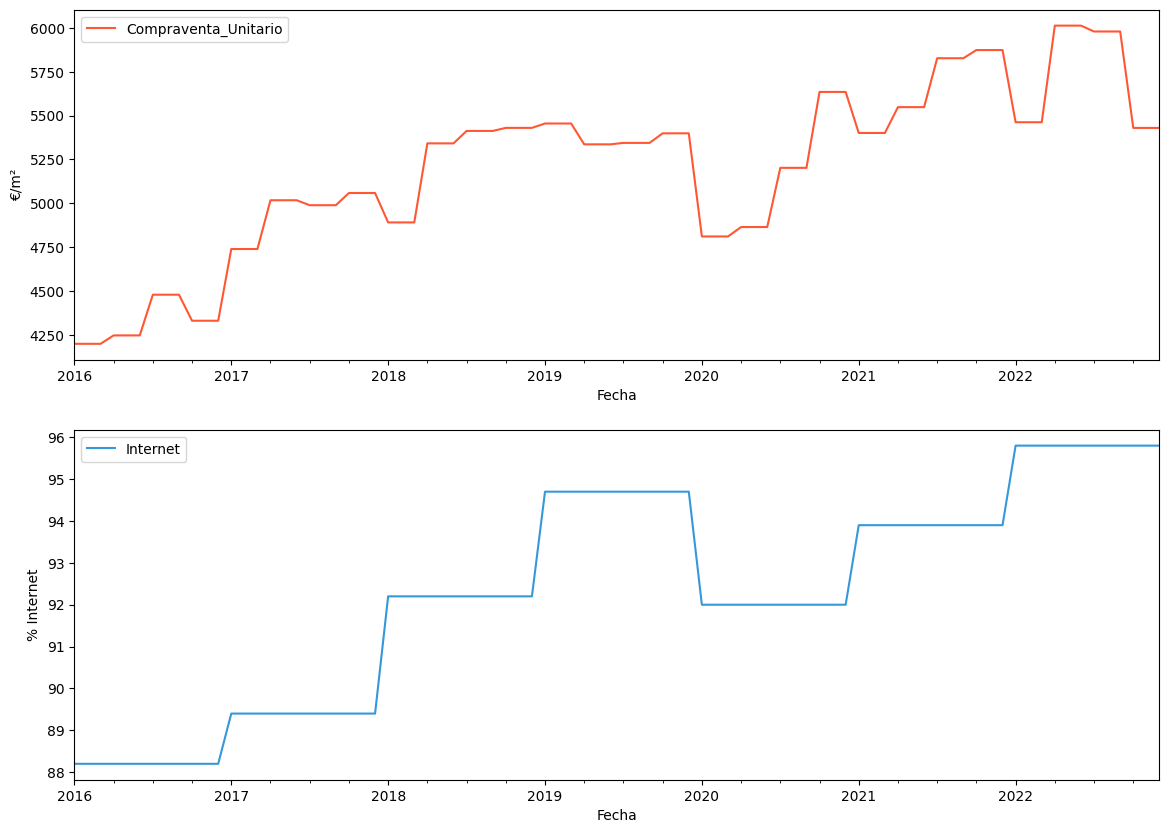

In [14]:
fig, axes = plt.subplots(nrows = int(len(df.columns)), ncols = 1, dpi = 100, figsize = (14,10))
unidades = ['€/m²', '% Internet']
colores = ['#FF5733', '#3498DB']

for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df[col].plot(color = colores[i], legend = True, ax = ax)
    ax.set_ylabel(unidades[i])  # Establecer etiqueta del eje y
plt.show()

Cada una de las series tiene patrones de tendencia muy diferentes entre si

In [15]:
corr=df.corr()
corr

,Compraventa_Unitario,Internet
Compraventa_Unitario,1.000000,0.840738
Internet,0.840738,1.000000


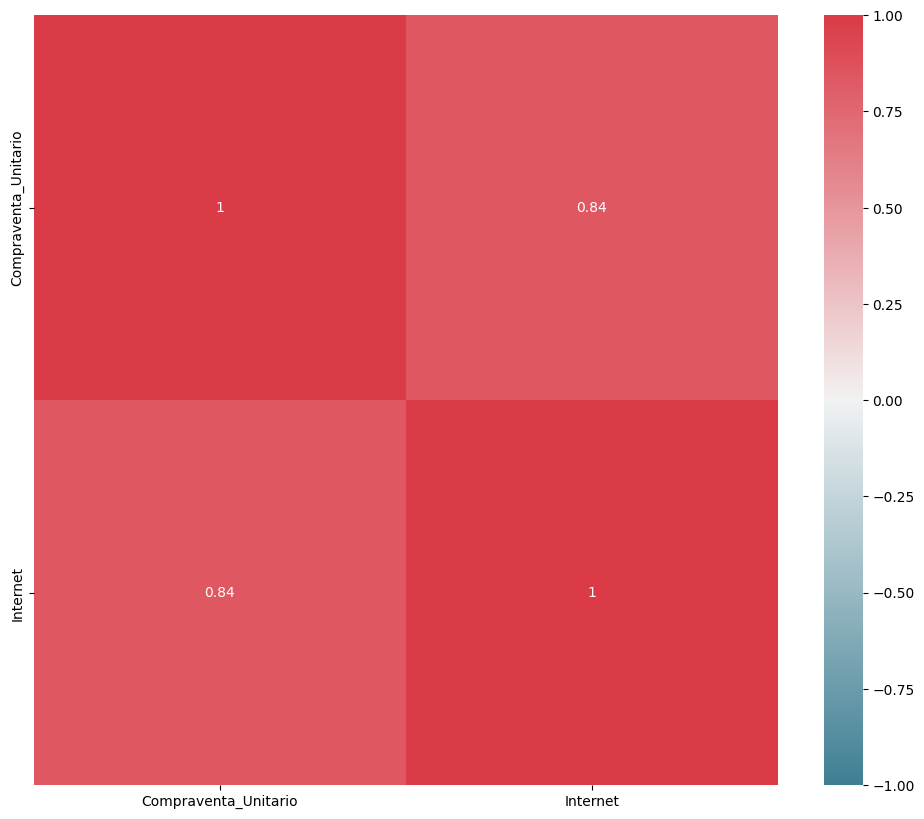

In [16]:
import seaborn as sb
fig, ax = plt.subplots(figsize=(12, 10))

sb.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot=True,vmax=1, vmin=-1, cmap =sb.diverging_palette(220, 10, as_cmap=True),center=0,ax=ax )
plt.show()

La correlación entre "Compraventa_Unitario" y "Internet" es de 0.840738, lo que sugiere una correlación muy alta entre estas dos variables en el modelo.

### Dividir los datos en conjunto de Entrenamiento y Prueba


In [17]:
fecha_division = '2022-07-01'

X_train, X_test = df[df.index<fecha_division], df[df.index>=fecha_division]
print(X_train.shape, X_test.shape)


(78, 2) (6, 2)


Los modelos siguientes se ajustarán al conjunto de entrenamiento X_train y luego se utilizará el modelo para pronosticar las observaciones futuras. Estos pronósticos se compararán con los datos reales del conjunto de prueba.



###Test de Cointegracion

Determinaremos si las dos variables estan relacionadas entre si y si esa relacion es duradera o no

In [18]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df):
    res = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = res.lr1
    cvts = res.cvt[:, d[str(1-0.05)]]
    def adjust(val, length= 6):
        return str(val).ljust(length)
    print('Column Name   >  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), '> ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

In [19]:
cointegration_test(X_train[['Compraventa_Unitario', 'Internet']])

Column Name   >  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Compraventa_Unitario >  9.78      > 12.3212   =>   False
Internet >  2.77      > 4.1296    =>   False


- **Compraventa_Unitario** muestra evidencia de cointegración, lo que sugiere que las variables incluidas tienen una tendencia a largo plazo a moverse juntas, manteniendo una relación de equilibrio.
- **Internet** no muestra evidencia de cointegración, lo que significa que las series relacionadas no tienden a volver a un equilibrio común a largo plazo bajo el modelo actual.

Para un análisis conjunto, dado que una de las series esta cointegrada y la otra no, se consideran principalmente 2 modelos, VAR y VECM

### Prueba de estacionariedad

Necesitamos que los datos sean estacionarios para poder usar el modelo VAR. Vamos a averiguarlo haciendo un Test de Dickey-Fuller aumentado, a cada variable univariante que tiene nuestro dataset.

In [20]:
import statsmodels.tsa.stattools as sts

In [21]:
def augmented_dickey_fuller_statistics(time_series):
  result = sts.adfuller(time_series.values)
  print('p-value: %f' % result[1])

print('Test de Dickey-Fuller Aumentado:')
for i in range(len(X_train.columns)):
  print('Serie de tiempo',X_train.columns[i])
  augmented_dickey_fuller_statistics(X_train.iloc[:,i])

Test de Dickey-Fuller Aumentado:
Serie de tiempo Compraventa_Unitario
p-value: 0.483986
Serie de tiempo Internet
p-value: 0.702439


Los p-valores son mayores que 0.05, con lo cual no se rechaza la hipótesis nula de que la serie no es estacionaria. Habría que transformar los datos porque no se puede confirmar estacionariedad.

In [22]:
#Diferenciando por primera vez
X_train_transformed=X_train.diff().dropna()
X_train_transformed.head()

,Compraventa_Unitario,Internet
Fecha,,
2016-02-01,0.000000,0.0
2016-03-01,0.000000,0.0
2016-04-01,47.933333,0.0
2016-05-01,0.000000,0.0
2016-06-01,0.000000,0.0


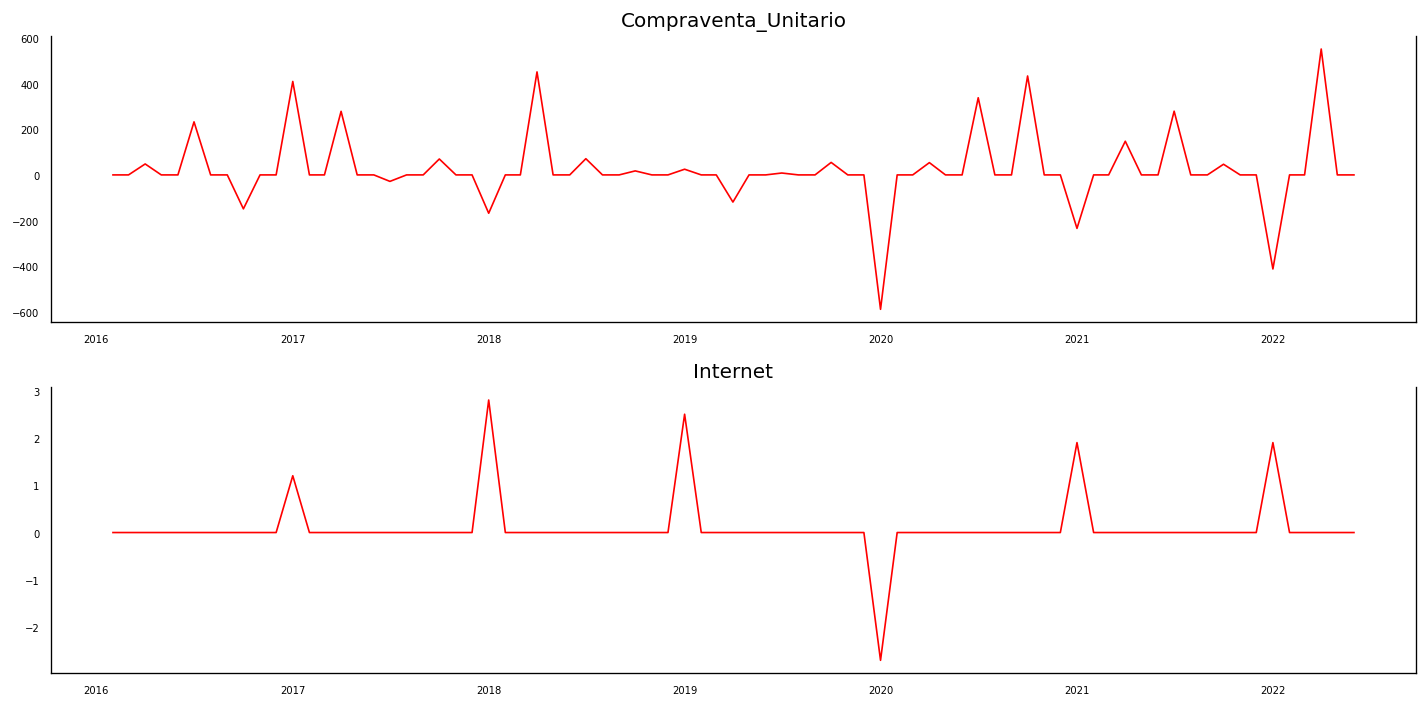

In [23]:
# Plot
fig, axes = plt.subplots(nrows=2, ncols=1, dpi=120, figsize=(12,6))
for i, ax in enumerate(axes.flatten()):
    data = X_train_transformed[X_train_transformed.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(X_train_transformed.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [24]:
print('Test de Dickey-Fuller Aumentado 2da vez:')
for i in range(len(X_train_transformed.columns)):
  print('Serie de tiempo transformada', 'Variable', X_train_transformed.columns[i])
  augmented_dickey_fuller_statistics(X_train_transformed.iloc[:,i])

Test de Dickey-Fuller Aumentado 2da vez:
Serie de tiempo transformada Variable Compraventa_Unitario
p-value: 0.000000
Serie de tiempo transformada Variable Internet
p-value: 0.000000


Todos los p-valores son < 0.05 por lo tanto se podría concluir que con 1 orden de diferenciación se obtienen series estacionarias.

### Modelo VAR

El modelo VAR es una extension del modelo ARIMA para multiples series temporales, es decir en vez de modelar una sola srie temporal, el VAR modela simultaneamente todas las series temporales de un sistema.
Cada serie temporal se regresa en función de usus propios valores pasados y de los valores pasados de las otras series temporales.
**Es util cuando las diferentes series temporales estan interrelacionadas y se influyen mutuamente.**




In [25]:
from statsmodels.tsa.api import VAR

In [26]:
model = VAR(X_train_transformed)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


#### Seleccionando el orden del modelo

In [27]:
modelsel=model.select_order(8)
modelsel.summary()

,AIC,BIC,FPE,HQIC
0,9.351*,9.416*,1.151e+04*,9.377*
1,9.465,9.659,1.290e+04,9.542
2,9.579,9.902,1.446e+04,9.707
3,9.526,9.979,1.373e+04,9.706
4,9.640,10.22,1.542e+04,9.871
5,9.755,10.47,1.733e+04,10.04
6,9.722,10.56,1.684e+04,10.06
7,9.836,10.81,1.897e+04,10.22
8,9.951,11.05,2.140e+04,10.39


Los criterios de selección de modelo como AIC, BIC, FPE y HQIC se utilizan para elegir el mejor orden de un modelo VAR. En este caso, el orden de rezago 0 muestra los valores mínimos en todos los criterios, lo que sugiere que es la opción preferida para el modelo. Esto implica que un modelo VAR sin rezagos es el más adecuado según estos criterios de evaluación.

Dado que una de las variables tiene datos anuales, se adopta VAR(12)

#### Ajustando el modelo

In [28]:
res = model.fit(maxlags=12)
res.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 28, May, 2024
Time:                     17:19:32
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    11.5070
Nobs:                     65.0000    HQIC:                   10.4944
Log likelihood:          -454.080    FPE:                    20288.5
AIC:                      9.83441    Det(Omega_mle):         10582.6
--------------------------------------------------------------------
Results for equation Compraventa_Unitario
                              coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------------
const                           37.040779        24.487799            1.513           0.130
L1.Compraventa_Unitario         -0.040130         0.136092           -0.295           0.768
L

La correlación entre los residuos de "Compraventa_Unitario" y los residuos de "Internet" es de 0.184071, lo que sugiere una correlación leve entre los residuos de estas dos variables en el modelo.

In [29]:
res.is_stable()

True

In [30]:
X_train.columns

Index(['Compraventa_Unitario', 'Internet'], dtype='object')

###### Causalidad de Granger

In [31]:
grangercaus=res.test_causality(['Internet'],['Compraventa_Unitario'],kind='f')
grangercaus.summary()

Test statistic,Critical value,p-value,df
1.871,1.875,0.051,"(12, 80)"


In [32]:
grangercaus=res.test_causality(['Compraventa_Unitario'],['Internet'],kind='f')
grangercaus.summary()

Test statistic,Critical value,p-value,df
1.293,1.875,0.239,"(12, 80)"


Como se puede observar, la causalidad de Granger nos indica que ninguna de las series temporales puede predecir la otra serie temporal

###### Matriz de causalidad de Granger


In [33]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import grangercausalitytests
import warnings
warnings.filterwarnings("ignore")
maxlag=12
test = 'ssr_chi2test'
def grangers_causality_matrix(X_train_transformed, variables, test = 'ssr_chi2test', verbose=False):
  dataset = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
  for c in dataset.columns:
    for r in dataset.index:
      test_result = grangercausalitytests(X_train_transformed[[r,c]], maxlag=maxlag, verbose=False)
      p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
      if verbose:
        print(f'Y = {r}, X = {c}, P Values = {p_values}')
      min_p_value = np.min(p_values)
      dataset.loc[r,c] = min_p_value
  dataset.columns = [var + '_x' for var in variables]
  dataset.index = [var + '_y' for var in variables]
  return dataset
grangers_causality_matrix(X_train_transformed, variables = X_train_transformed.columns)

,Compraventa_Unitario_x,Internet_x
Compraventa_Unitario_y,1.0,0.0139
Internet_y,0.0,1.0000


Con esta matriz queda claro que la serie temporal de Compraventa_Unitario no causa ni es causada por la otra serie temporal de ParadosReg

### Diagnosis del modelo


###### Residuos

In [34]:
residuals=res.resid

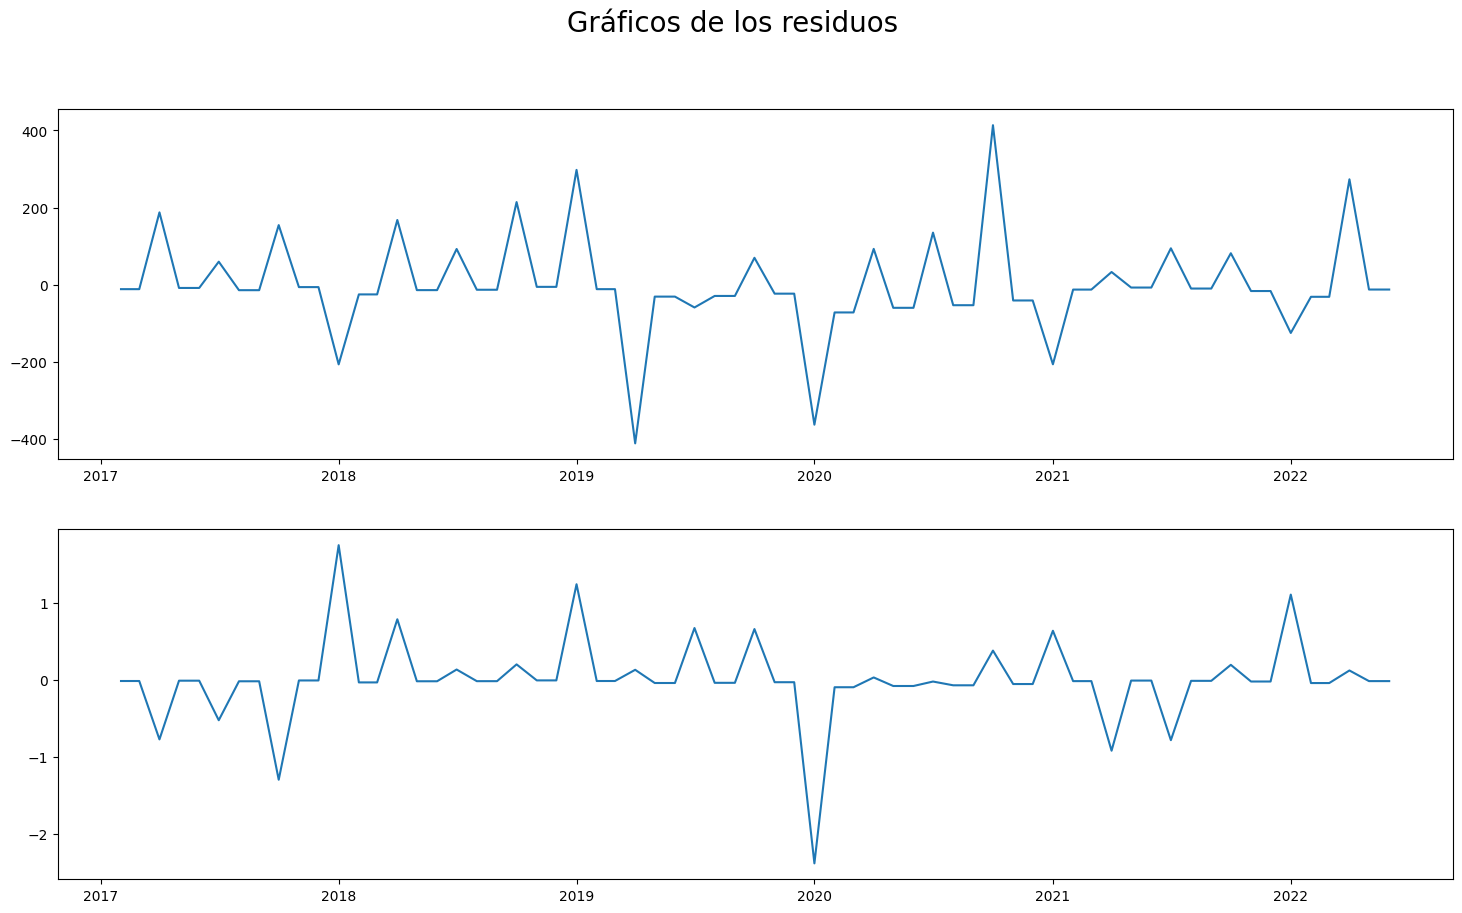

In [35]:
fig, axs = plt.subplots(2)
fig.suptitle('Gráficos de los residuos',fontsize=20)
fig.set_size_inches(18, 10)
[axs[i].plot(residuals.iloc[:,i]) for i in range(2)]
plt.show()

###### Dickey - Fuller a los residuos


In [36]:
print('ADF de los Residuos, p-valores:')
[sts.adfuller(residuals.iloc[:,i])[1] for i in range(2)]

ADF de los Residuos, p-valores:


[2.3990928006971222e-12, 5.046988009607258e-12]

Todos los p-valores son < 0.1 por tanto se rechaza la hipótesis nula de que las 3 series de residuos no son estacionarias, por lo cual con un 90% de confianza se cree que son estacionarias.



###### ACF de los Residuos


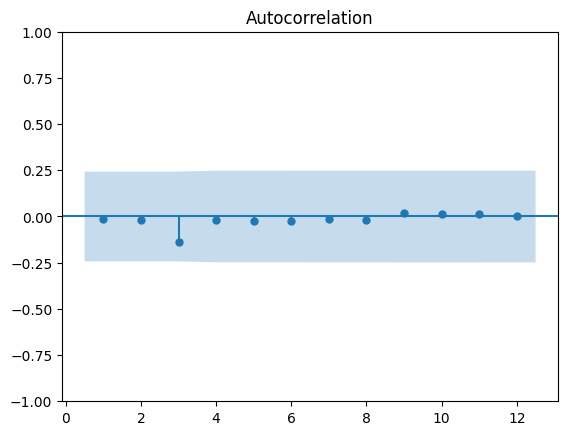

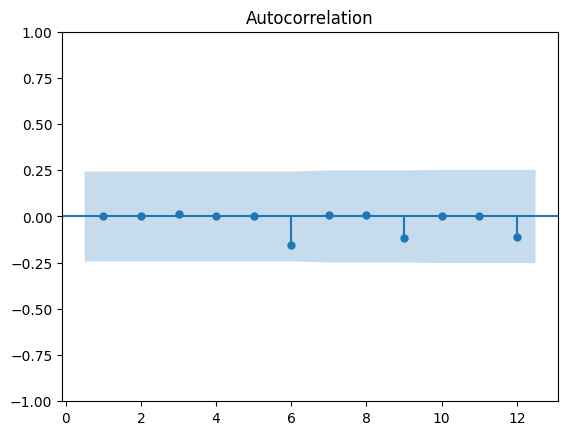

In [37]:
import statsmodels.graphics.tsaplots as sgt
[sgt.plot_acf(residuals.iloc[:,i], zero = False, lags = 12) for i in range(2)]
plt.show()

Conclusión: Los residuos del modelo no presentan estructura de autocorrelación, son estacionarios según los resultados de la prueba de Dickey - Fuller aumentada y en los gráficos se puede comprobar esto visualmente, entonces puede concluirse que son ruido blanco como es deseable.



#### Valores predichos


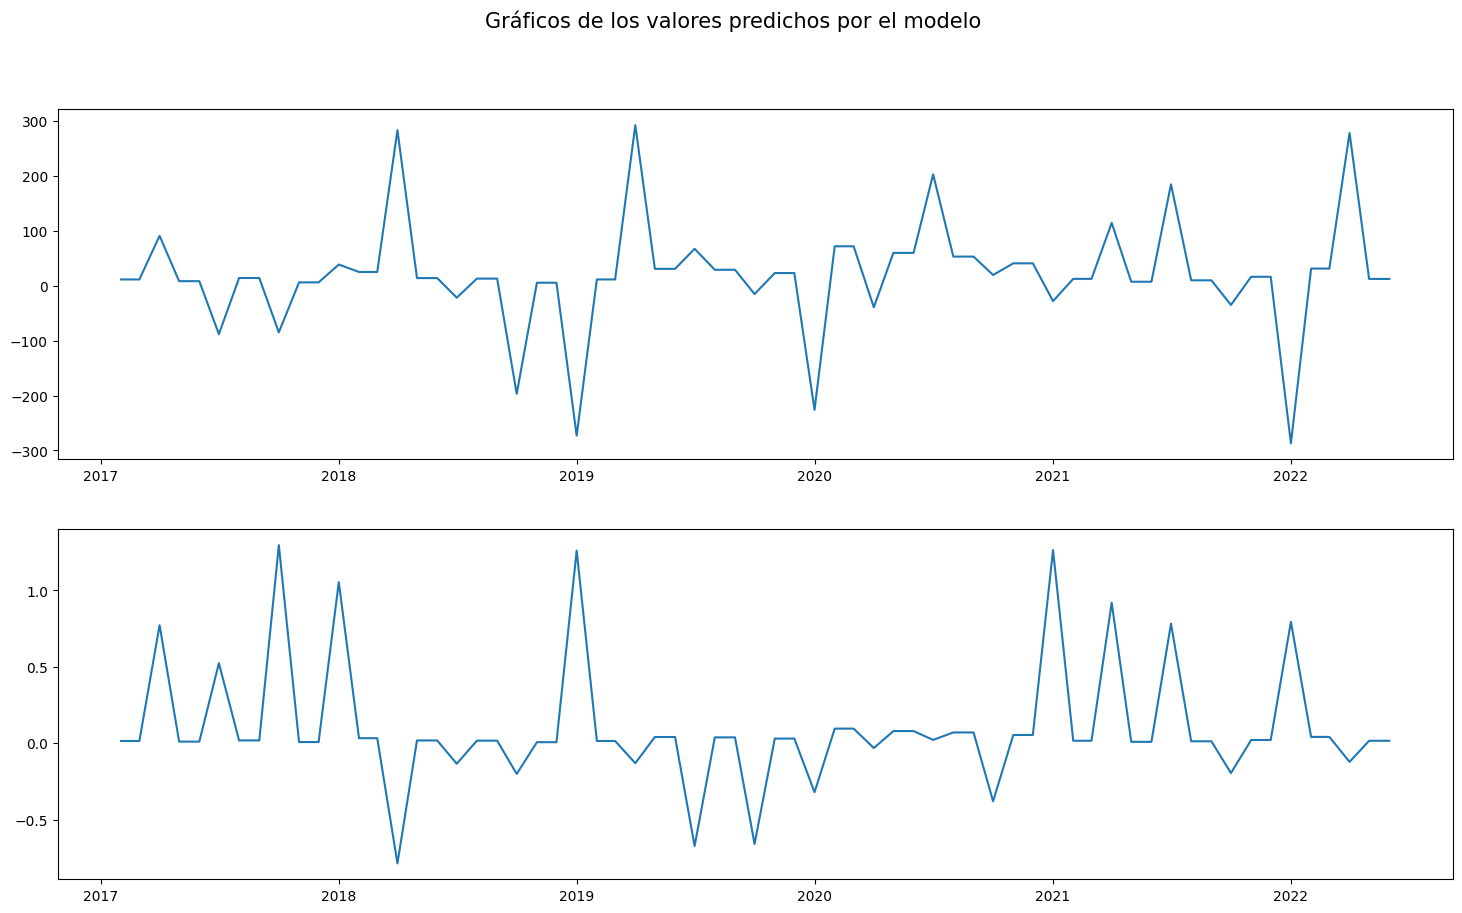

In [38]:
y_fitted = res.fittedvalues
fig, axs = plt.subplots(2)
fig.suptitle('Gráficos de los valores predichos por el modelo',fontsize=15)
fig.set_size_inches(18, 10)
[axs[i].plot(y_fitted.iloc[:,i]) for i in range(2)]
plt.show()

#### Pronósticos a futuro


Para pronosticar, al modelo VAR le podemos pasar hasta el número de orden de retraso de observaciones de los datos pasados. Esto se debe a que los términos en el modelo VAR son esencialmente los retrasos de las diversas series de tiempo en el conjunto de datos, por lo que debemos proporcionar tantos valores anteriores como lo indique el orden de retraso utilizado por el modelo. De lo contrario estaríamos introduciendo poca fiabilidad.



In [39]:
# Obtener el orden del modelo
lag_order = res.k_ar
print('Orden del modelo:', lag_order)
# Input data para hacer forecasting (pronósticos a futuro)
input_data = X_train_transformed.values[-lag_order:]
# Forecasting
pred = res.forecast(y=input_data, steps=6)
pred = (pd.DataFrame(pred, index=X_test.index, columns=X_test.columns + '_pred'))
print('Predicciones:')
pred

Orden del modelo: 12
Predicciones:


,Compraventa_Unitario_pred,Internet_pred
Fecha,,
2022-07-01,105.032949,-0.064523
2022-08-01,21.715917,0.029073
2022-09-01,20.742112,0.027769
2022-10-01,-228.924187,-0.464679
2022-11-01,20.938211,0.056193
2022-12-01,20.187766,0.053925


<Figure size 1200x1000 with 0 Axes>

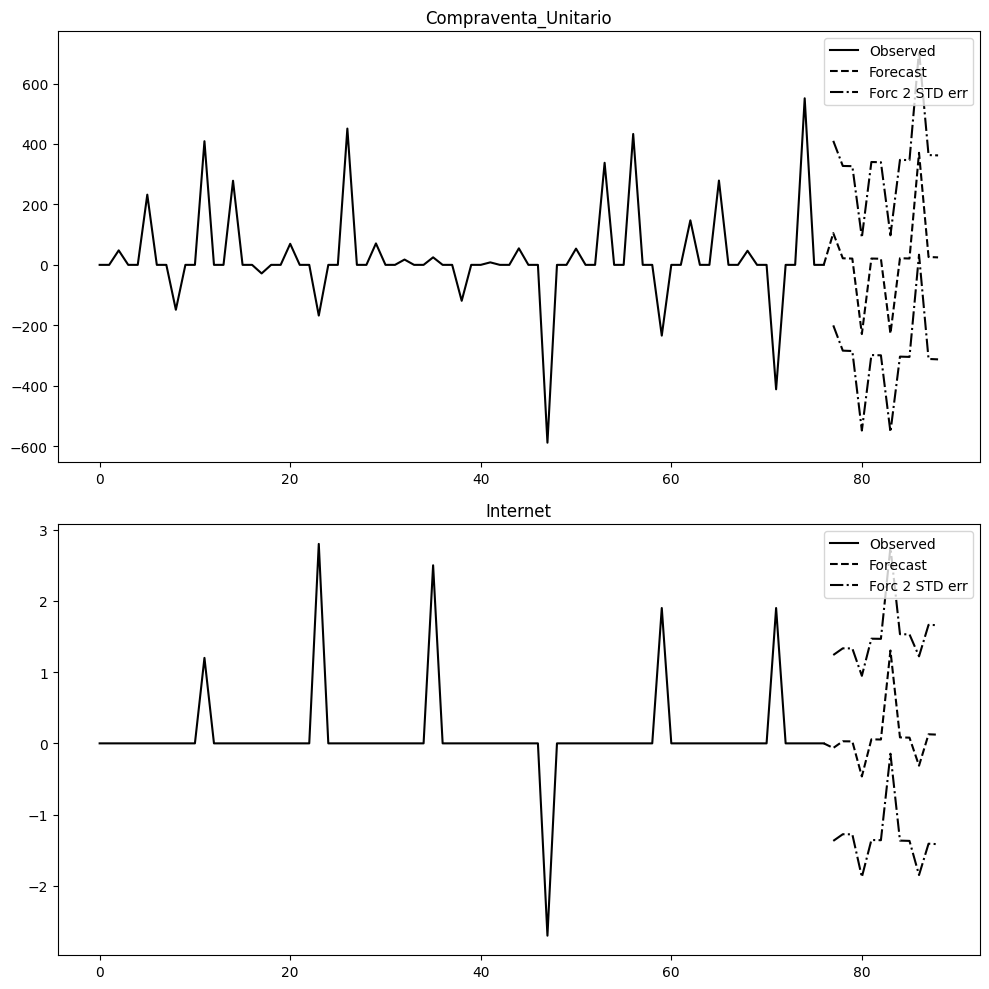

In [40]:
import matplotlib.pyplot as plt
plt.figure(figsize = (12, 10))
res.plot_forecast(lag_order)
plt.tight_layout(h_pad = 1.15)
plt.show()


#### Invirtiendo la transformación de los pronósticos a la escala original


Los pronósticos se generan en la escala de los datos de entrenamiento utilizados por el modelo, es decir, son datos transformados. Entonces, para volver a ponerlos en su escala original, necesitamos des-diferenciarlos. La forma de invertir la diferenciación es sumar estas diferencias consecutivamente al número base. Una forma sencilla de hacerlo es determinar primero la suma acumulada y luego sumarla al número base. Este proceso se puede revertir agregando la observación en el paso de tiempo anterior al difference value. inverted(ts) = differenced(ts) + observation(ts-1)



In [41]:
# Invirtiendo la transformación teniendo en cuenta que hemos diferenciado dos veces
def invert_transformation(ds, df_forecast, second_diff=False):
    for col in ds.columns:
        # Undo the 2nd Differencing
        if second_diff:
            df_forecast[str(col)] = (ds[col].iloc[-1] - ds[col].iloc[-2]) + df_forecast[str(col)].cumsum()

        # Undo the 1st Differencing
        df_forecast[str(col)] = ds[col].iloc[-1] + df_forecast[str(col)].cumsum()

    return df_forecast

In [42]:
pred.columns=X_test.columns
output = invert_transformation(X_train, pred, second_diff=False)
output

,Compraventa_Unitario,Internet
Fecha,,
2022-07-01,6118.616282,95.735477
2022-08-01,6140.332199,95.764550
2022-09-01,6161.074312,95.792319
2022-10-01,5932.150125,95.327640
2022-11-01,5953.088336,95.383832
2022-12-01,5973.276102,95.437757


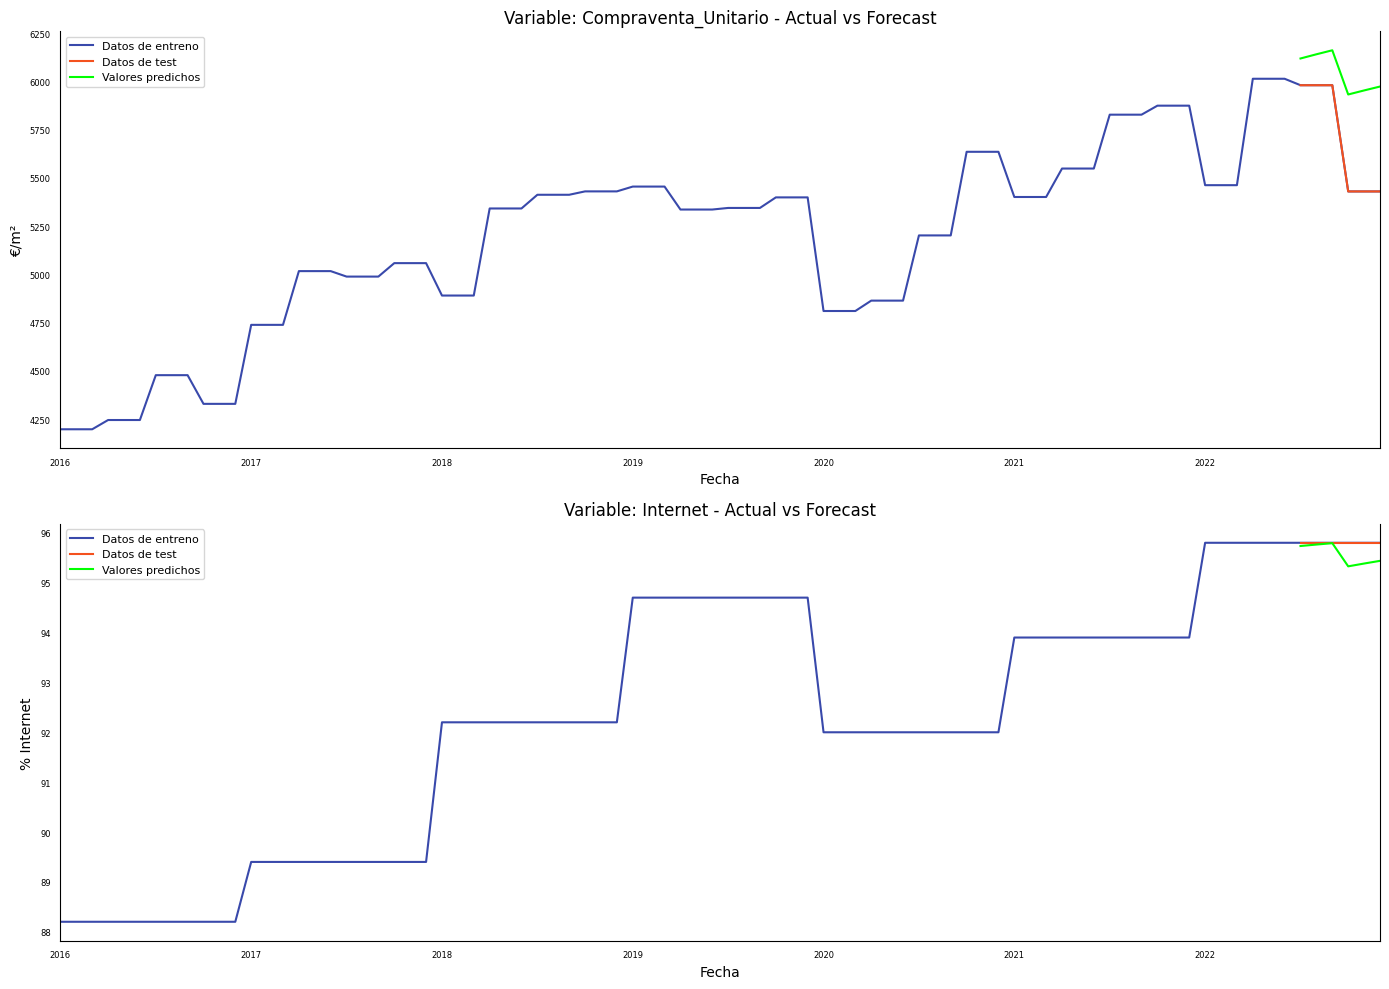

In [43]:
# Actual vs Forecasted Plots
fig, axes = plt.subplots(nrows = int(len(X_train.columns)), ncols = 1, dpi = 100, figsize = (14,10))
mi_lista = ['€/m²', '% Internet']

for i, (col,ax) in enumerate(zip(X_train.columns, axes.flatten())):
    df[col].plot(color = '#3949AB', legend = True, ax = ax)
    X_test[col].plot(color = '#F4511E', legend = True, ax = ax)
    output[col].plot(color = '#00FF00', legend = True, ax = ax).autoscale(axis =' x',tight = True)

    ax.set_title('Variable: ' + col + ' - Actual vs Forecast')
    ax.set_ylabel(mi_lista[i])  # Establecer etiqueta del eje y
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')

    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize = 6)

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, ['Datos de entreno', 'Datos de test', 'Valores predichos'], loc='upper left', fontsize=8)

plt.tight_layout()
plt.savefig('actual_forecast.png')
plt.show()

#### Evaluando el modelo


In [44]:
def timeseries_evaluation_metrics_func(y_true, y_pred):

    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [45]:
for i in ['Compraventa_Unitario','Internet']:
    print(f'Evaluation metric for {i}')
    timeseries_evaluation_metrics_func(X_test[str(i)] , output[str(i)])

Evaluation metric for Compraventa_Unitario
Evaluation metric results:-
MSE is : 149762.3651629006
MAE is : 341.3728923760709
RMSE is : 386.99142776410514
MAPE is : 6.151370806016918
R2 is : -0.9793689851625307

Evaluation metric for Internet
Evaluation metric results:-
MSE is : 0.0888364008229794
MAE is : 0.22640415979909534
RMSE is : 0.29805435883908726
MAPE is : 0.23633002066711412
R2 is : 0.0



Los resultados de las métricas de evaluación indican que el modelo para Compraventa_Unitario tiene un MSE, MAE y RMSE altos, sugiriendo errores significativos en las predicciones. El MAPE de 4.73% indica un error porcentual moderado, pero el R² negativo (-0.4836) revela que el modelo no captura la variabilidad de los datos. En contraste, el modelo para Internet muestra un MSE y MAE bajos, con un MAPE de 1.06%, sugiriendo predicciones más precisas. Sin embargo, el R² de 0 indica que el modelo no explica la variabilidad de los datos. En resumen, el modelo de Internet parece más preciso pero carece de capacidad explicativa, mientras que el de Compraventa_Unitario presenta errores significativos y un desempeño deficiente.

In [46]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
print('Mean absolute error:', mean_absolute_error(X_test, output))
print('Root mean squared error:', np.sqrt(mean_squared_error(X_test, output)))

Mean absolute error: 170.799648267935
Root mean squared error: 273.64434399353246


### Modelo VARMA (Auto Arima)

El modelo VARMA (Vector Autoregressive Moving Average) es una técnica estadística utilizada en análisis de series temporales que combina los modelos VAR (Vector Autoregressive) y MA (Moving Average). Es especialmente útil cuando se trata de series temporales múltiples, permitiendo modelar la interdependencia entre varias series a lo largo del tiempo junto con términos de error autocorrelacionados.

In [47]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 8.7 MB/s eta 0:00:00


#### Ajustando el modelo

#####Auto Arima

Aplicaremos autoarima, para determinar los valores de p, q y d

In [48]:
import pmdarima as pm

In [49]:
pq = []
for name in ['Compraventa_Unitario', 'Internet']:
    print(f'Searching order of p and q for : {name}')
    # Ajusta un modelo ARIMA para cada columna
    stepwise_model = pm.auto_arima(X_train_transformed[name],
                                start_p=0, start_q=0,
                                max_p=4, max_q=4,
                                seasonal=False,
                                trace=True,
                                error_action='ignore',
                                suppress_warnings=True,
                                stepwise=True,
                                maxiter=1000)
    # Obtiene los parámetros óptimos de p y q del modelo
    parameter = stepwise_model.get_params().get('order')
    print(f'optimal order for:{name} is: {parameter} \n\n')
    # Agrega los parámetros óptimos a la lista pq
    pq.append(stepwise_model.get_params().get('order'))

Searching order of p and q for : Compraventa_Unitario
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=997.801, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=999.801, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=999.801, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1001.801, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=998.013, Time=0.02 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.180 seconds
optimal order for:Compraventa_Unitario is: (0, 0, 0) 


Searching order of p and q for : Internet
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=148.038, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=150.038, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=150.038, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=152.038, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=148.091, Time=0.13 sec

Best model:  ARIMA(0,0,0)(0,0,0)[

In [50]:
pq

[(0, 0, 0), (0, 0, 0)]

- *p=0:* Indica que no hay términos autoregresivos en el modelo. En otras palabras, el modelo VARMA no incluye dependencia de los valores pasados de las variables en sí mismas.

- *q=0:* Indica que no hay términos de medias móviles en el modelo. Esto significa que no hay dependencia de los errores pasados del modelo en sí mismo.

En este caso no se puede aplicar el modelo VARMA, ya que el modelo esta considerando unicamente la tendencia lineal y no esta incorporando autocorrelacion en los residuos del modelo.


##Conclusiones

El análisis de las series temporales de "Compraventa_Unitario" e "Internet" reveló una alta correlación entre ambas variables (0.840738). La prueba de cointegración mostró que "Compraventa_Unitario" está cointegrada, mientras que "Internet" no. Ambas series no eran estacionarias inicialmente, pero se volvieron estacionarias tras diferenciarlas una vez. Se seleccionó un modelo VAR de orden 12, que demostró ser estable con residuos que eran ruido blanco. Sin embargo, la prueba de causalidad de Granger no encontró evidencia de que una serie pueda predecir a la otra.

En términos de evaluación, el modelo VAR para "Compraventa_Unitario" presentó altos MSE, MAE y RMSE, y un R² negativo, indicando un mal desempeño. Para "Internet", el modelo mostró MSE y MAE bajos, con un MAPE bajo, pero un R² de 0, sugiriendo una falta de capacidad explicativa. La aplicación de un modelo VARMA no fue posible debido a la falta de términos autoregresivos y de medias móviles significativos.

En resumen, el modelo VAR es adecuado para "Internet" pero no para "Compraventa_Unitario". Se recomienda explorar modelos adicionales y considerar variables exógenas para mejorar la capacidad predictiva y explicativa del modelo.